In [1]:
import sys
!{sys.executable} -m pip install iminuit==2.2.1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/bin/python3.6m -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
fName = '/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/datafortres.csv'

In [4]:
data = pd.read_csv(fName)

[[-2.95808539e+00  6.18495839e+01]
 [-3.52602825e+01  2.86546117e+01]
 [-7.81839955e+01  2.46316185e+05]
 ...
 [-2.18337588e+01  1.65001687e+01]
 [-4.11162153e+00  1.89113733e+01]
 [-1.17881615e+02  1.40098119e+02]]


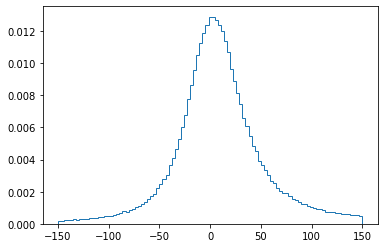

In [5]:
vData1 = data['tagvlres'].to_numpy()
#vData1 = vData[~np.isnan(vData)] # nts: come back to this and match the N/A to corresp sigmas
sigmas = data['tagvlerr'].to_numpy()
#vData1.resize(min(len(vData1), len(vData1)))
#sigmas.resize(min(len(sigmas), len(sigmas)))
vData1.size, sigmas.size
vData = np.column_stack((vData1,sigmas))

#all the input array dimensions for the concatenation axis must match exactly,
#but along dimension 0, the array at index 0 has size 464981 and the array at index 1 has size 466977
plt.hist(vData[:,0], histtype='step', density = True, bins=np.linspace(-150, 150, 100))
print(vData)

In [6]:
def gausInt(a, b, c, d):
     m = d / c
     s = 1./np.sqrt(c) # ?
     from math import erf
     res = np.sqrt(np.pi)/(2*np.sqrt(c)) * (erf((b*c-d)/np.sqrt(c)) - erf((a*c-d)/np.sqrt(c)))
     return res

def convExpGaus(sK, tau, x):  
     c = 1./(2*sK*sK)
     d = 0.5*(x/sK/sK - 1/tau)
     Const = 1./(np.sqrt(2*np.pi) *sK* tau) * np.exp(-1./2 * pow(x/sK,2) + d*d/c)
     return Const * gausInt(0, 1e15, c, d); #tu sa vola erf 
  
def Gauss(x,sigma, mean, ):
    f = 1./(np.sqrt(2*np.pi)*sigma) * np.exp( -1./2 * pow((x-mean)/sigma, 2))
    return f

def mu(sigma,mu0,mu1):
    mus = 0
    mus = mu0 + mu1*sigma
    return mus
        
def sus(sigma,s0,s1):
    res_sus = 0
    res_sus = s0 + s1*sigma
    return res_sus 
        
def fTMains(sigma,f_mu,f_sig, f_Mmax):
    res_fTMains = 0
    from math import erf
    res_fTMains = (f_Mmax)*erf((f_mu-sigma)/(np.sqrt(2)*f_sig))
    return res_fTMains
        
def fTBigs(sigma,f_mu,f_sig, f_Bmax):
    res_fTBigs = 0
    from math import erf
    res_fTBigs = (f_Bmax)*erf((f_mu-sigma)/(np.sqrt(2)*f_sig))
    return res_fTBigs
        
def cLMs(sigma,c0LM, c1LM): #pozor na obratenu hodnotu v zapise...
    res_cLMs = 0
    res_cLMS = 1/(c0LM + c1LM*sigma)
    return res_cLMs
      
def cRMs(sigma,c0RM, c1RM): #pozor na obratenu hodnotu v zapise...
    res_cRMs = 0
    res_cRMS = 1/(c0RM + c1RM*sigmas)
    return res_cRMs
        
def cB(sigma,c0B,c1B):
    res_CB = 0
    res_CB = 1/(c0B + c1B*sigma)
    return res_CB

def fun(x, pars,sigmas):
    #fTMains = pars["fTMains"]
    f_mu = pars["f_mu"]
    f_sig = pars["f_sig"]
    f_Mmax = pars["f_Mmax"]
    fTR     = pars["fTR"]
   # sigmas  = pars["sigmas"]
    #cLMs    = pars["cLMs"]
    #cRMs    = pars["cRMs"]
   # mus     = pars["mus"]
           
    mu0 = pars["mu0"]
    mu1 = pars["mu1"]
    s0 = pars["s0"]
    s1 = pars["s1"]    
    bigSigmaFrac = pars['bigSigmaFrac'] # Co je to?
    
    #fTBigs = pars['fTBigs']
    f_Bmax = pars["f_Bmax"]
    
    bigSigmaScale = pars['bigSigmaScale']
    #cLBs = pars['cLBs']
    #cRBs = pars['cRBs']
    c0RM = pars['c0RM']
    c1RM = pars['c1RM']
    c0LM = pars['c0LM']
    c1LM = pars["c1LM"]
    c0B = pars["c0B"]
    c1B = pars["c1B"]
    
    ret = 0
    
    # small gauss
    ret += (1-bigSigmaFrac) * (1-fTMains(sigmas,f_mu,f_sig, f_Mmax)) * Gauss(x,sigmas, mean=mus(sigmas,mu0,mu1) )
    ret += (1-bigSigmaFrac) * fTMains(sigmas,f_mu,f_sig, f_Mmax)*(1.-fTR)*convExpGaus(sigmas, 1./cLMs(sigmas,c0LM, c1LM), mus(sigmas,mu0,mu1) - x)
    ret += (1-bigSigmaFrac) * fTMains(sigmas,f_mu,f_sig, f_Mmax)*(fTR)*convExpGaus(sigmas, 1./cRMs(sigmas,c0RM, c1RM),  x - mus(sigmas,mu0,mu1) )
    # big gauss
    ret += bigSigmaFrac * (1-fTBigs(sigma,f_mu,f_sig, f_Bmax)) * Gauss(x, mean=mus, sigma=bigSigmaScale*sigmas)
    ret += bigSigmaFrac * fTBigs(sigma,f_mu,f_sig, f_Bmax)*(1.-fTR)*convExpGaus(bigSigmaScale*sigmas, 1./cB(sigma,c0B,c1B), mus(sigmas,mu0,mu1) - x)
    ret += bigSigmaFrac * fTBigs(sigma,f_mu,f_sig, f_Bmax)*(fTR)*convExpGaus(bigSigmaScale*sigmas, 1./cB(sigma,c0B,c1B),  x - mus(sigmas,mu0,mu1) )
    
    return ret




In [7]:
import chebFitterSig as chf
xLim = 500
sLim = 500
size = len(sigmas)
ch = chf.chebFitter(128 + 1, -xLim, xLim, size, -sLim, sLim, vData, fun)
#pars = {"mus" : 0, "sigmas" : 30,  "fTMains" : 0.9, "fTR" : 0.5,  "cLMs" : 0.1, "cRMs" : 0.1 }
pars = {
    # 'mus': 2.5998222326911318,
    #'sigmas': 19.488840799952847,
    'mu0': 2.5998222326911318,
    'mu1': 2.5998222326911318,
    's0' : 19.488840799952847,
    's1' : 19.488840799952847,
    #'fTMains': 0.6879121782503139,
    'f_mu' : 0.6879121782503139,
    'f_sig' : 0.6879121782503139,
    'f_Mmax' : 0.6879121782503139,
    
     'fTR': 0.5672982488332009,
     #'cLMs': 0.03847980216578396,
     #'cRMs': 0.02771982014064649,
     'bigSigmaScale': 6.947680846616044,
     'bigSigmaFrac': 0.16756917570490554,
     #'fTBigs': 0.6268934047143494,
    'f_Bmax' : 0.6268934047143494,
     #'cLBs': 0.0003812636576085269,
     #'cRBs': 0.006550526360797996,
     'c0RM': 0.02771982014064649,
    'c1RM' : 0.02771982014064649,
    'c0LM' : 0.03847980216578396,
    'c1LM' : 0.03847980216578396,
    'c0B' : 0.0003812636576085269,
    'c1B' : 0.006550526360797996
    
}
Limits = { 
        'mu0': (-10, 10),
        'mu1': (-10, 10),
        's0' : (2, 40),
        's1' : (2, 40),
        #'sigmas': (10, 40),
        # 'fTMains': (0, 1),
        'f_mu' : (0, 1),
        'f_sig' : (0, 1),
        'f_Mmax' : (0, 1),    
        'fTR': (0, 1),
        #'cLMs': (1e-5, 0.1),
        #'cRMs': (1e-5, 0.1),
        'c0RM': (1e-5, 0.1),
        'c1RM' : (1e-5, 0.1),
        'c0LM' : (1e-5, 0.1),
        'c1LM' : (1e-5, 0.1),
        'c0B' : (1e-5, 0.1),
        'c1B' : (1e-5, 0.1),
        "bigSigmaScale": (3, 40),
        'bigSigmaFrac' : (0,1),
        #'fTBigs' : (0,1),
        'f_Bmax': (0,1)
    
        #'cLBs' : (1e-5, 0.05),
        #'cRBs' : (1e-5, 0.05)
        }


res =  ch.fitData(pars, Limits)
print(res)


Loading data grid


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 1d, C), Literal[int](1), array(float64, 1d, C))
 
There are 16 candidate implementations:
[1m   - Of which 16 did not match due to:
   Overload of function 'setitem': File: <numerous>: Line N/A.
     With argument(s): '(array(float64, 1d, C), int64, array(float64, 1d, C))':[0m
[1m    No match.[0m
[0m
[0m[1mDuring: typing of staticsetitem at /nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/nodes.py (74)[0m
[1m
File "nodes.py", line 74:[0m
[1mdef getPolsFast(Size, x):
    <source elided>
    pol[0] = 1
[1m    pol[1] = C/2
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function getPolsFast at 0x7ff72d5e6c80>))[0m
[0m[1mDuring: typing of call at /nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/chebFitterSig.py (15)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function getPolsFast at 0x7ff72d5e6c80>))[0m
[0m[1mDuring: typing of call at /nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/chebFitterSig.py (15)
[0m
[1m
File "chebFitterSig.py", line 15:[0m
[1mdef calcLoopFast(Size, dataNorm):
    <source elided>
    for xx in dataNorm:
[1m        polSum += getPolsFast(Size, xx)
[0m        [1m^[0m[0m


In [ ]:
def plotHist(d, bins, chFit, res):
    vals, bins = np.histogram(d, bins)
    xCnt  = (bins[1:] + bins[:-1]) / 2
    xSize = (bins[1:] - bins[:-1]) / 2
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[16,3]}, figsize=(12,8))
    axs[0].set_yscale('log')
    axs[0].errorbar(xCnt, vals, xerr=xSize, yerr=np.sqrt(vals), ls='none', fmt="o")
    
    N = np.dot(vals, 2*xSize) 
    x = np.linspace(bins[0], bins[-1], 500)
    y = N * chFit.funFast(x, res)
    axs[0].plot(x, y)
    
    # plotRatio
    yRat= N * chFit.funFast(xCnt, res) 
    axs[1].errorbar(xCnt, vals/ yRat, xerr=xSize, yerr=np.sqrt(vals)/yRat, ls='none', fmt="o")
    

    

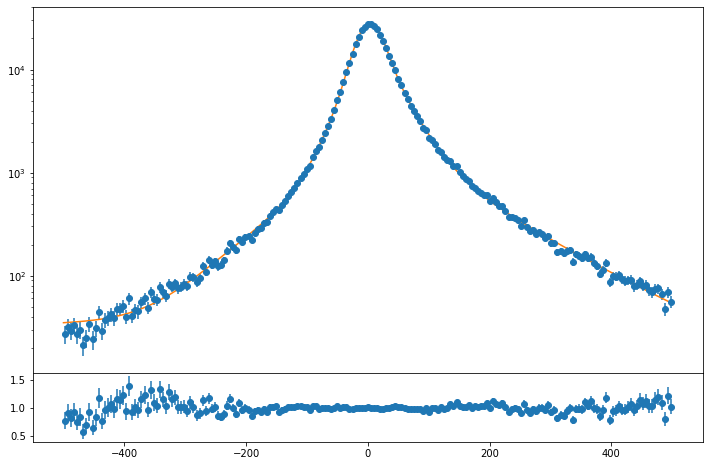

In [10]:
plotHist(vData, np.linspace(-xLim, xLim, 200), ch, res)